# Tutorial 03 - Visualize scan path on surface

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to visualize gaze positions and fixations on the surface.

1. Load the data using `Pandas`
1. Visualize fixation data as scan path on a surface

Raw Recording Data: To execute this notebook, download the [sample recording](https://drive.google.com/file/d/1vzjZkjoi8kESw8lBnsa_k_8hXPf3fMMC/view?usp=sharing). Unzip and move it into the `recordings` directory for this repository.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/sample_recording_v2.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/sample_recording_v2.zip
   creating: sample_recording_v2/
  inflating: sample_recording_v2/eye1_timestamps.npy  
  inflating: sample_recording_v2/notify_timestamps.npy  
  inflating: sample_recording_v2/gaze_timestamps.npy  
  inflating: sample_recording_v2/pupil.pldata  
  inflating: sample_recording_v2/world.intrinsics  
  inflating: sample_recording_v2/eye0_lookup.npy  
  inflating: sample_recording_v2/world_timestamps.npy  
  inflating: sample_recording_v2/eye0.mp4  
  inflating: sample_recording_v2/eye0_timestamps.npy  
  inflating: sample_recording_v2/world.mp4  
  inflating: sample_recording_v2/square_marker_cache  
  inflating: sample_recording_v2/notify.pldata  
  inflating: sample_recording_v2/surface_definitions_v01  
  inflating: sample_recording_v2/eye1.mp4  
  inflating: sample_recording_v2/pupil_timestamps.npy  
  inflating: sample_recording_v2/surface_definitions  
  inflating: sample_recording_v2/eye1_lookup.np

## 1 - Loading libraries and reference image

In this example, a participant is looking at a magazine.
Multiple pages of the magazine are tracked as [surfaces](https://docs.pupil-labs.com/core/software/pupil-capture/#surface-tracking). For this tutorial, we will analyze the magazine cover.

First, let's load the reference image of the magazine cover from a file.

Cover Reference Image


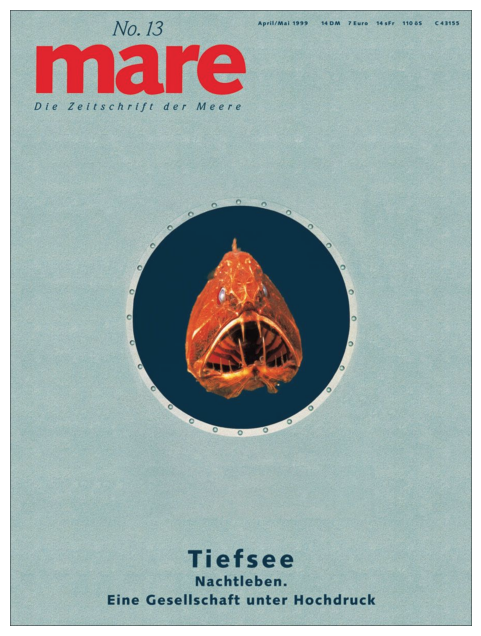

In [2]:
import numpy as np
import matplotlib.pyplot as plt

cover_img = plt.imread('/content/drive/MyDrive/pupil/data/cover_image.png')

print("Cover Reference Image")
plt.figure(figsize=(8,8))
plt.imshow(cover_img)
plt.axis('off');

## 2 - Loading Exported Surface Data

Now lets see how to load the exported fixation data for this surface. The file will be named with the pattern `fixations_on_surface_<your-surface-name>.csv`

In [3]:
import os
import pandas as pd
from pathlib import Path

# recording_location = Path(".") / "recordings" / "sample_recording_v2"
# surface_fixation_export = recording_location / "exports" / "000" / "surfaces" / "fixations_on_surface_Cover.csv"
surface_fixation_export = "/content/sample_recording_v2/exports/000/surfaces/fixations_on_surface_Cover.csv"

surface_df = pd.read_csv(surface_fixation_export)

print("Columns in surface dataframe:")
list(surface_df.columns)

Columns in surface dataframe:


['world_timestamp',
 'world_index',
 'fixation_id',
 'start_timestamp',
 'duration',
 'dispersion',
 'norm_pos_x',
 'norm_pos_y',
 'x_scaled',
 'y_scaled',
 'on_surf']

### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_timestamp` - The world camera timestamp of the start of the fixation.
- `world_index` - The frame number of the world camera at which the fixation starts.
- `fixation_id` - The id of the fixation. A sequential integer that shows the number of the fixation in order.
- `start_timestamp` - The starting timestamp of the fixation. This is the smallest eye camera timestamp of all involved gaze timestamps.
- `duration` - The duration of the fixation.
- `dispersion` - The dispersion of the fixation, in degrees.
- `norm_pos_x` - the normalized x position of the fixation relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the fixation is **not** on the surface.
- `norm_pos_y` - the normalized y position of the fixation relative to the surface.
- `x_scaled` and `y_scaled` - the position of the fixation relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture.
- `on_surf` - boolean value if gaze is within the bounds of the surface

Let's take a look at a few values from our sample surface data!

In [4]:
fixation_on_surf = surface_df[surface_df.on_surf == True]
pd.options.display.float_format = '{:.3f}'.format

print("Sample fixations on magazine cover:")
fixation_on_surf.head(5)

Sample fixations on magazine cover:


,world_timestamp,world_index,fixation_id,start_timestamp,duration,dispersion,norm_pos_x,norm_pos_y,x_scaled,y_scaled,on_surf
0,329357.975,121,18,329357.972,80.104,1.483,0.806,0.933,169.197,270.598,True
1,329358.009,122,18,329357.972,80.104,1.483,0.836,0.934,175.476,270.775,True
2,329358.042,123,18,329357.972,80.104,1.483,0.860,0.936,180.605,271.511,True
12,329359.785,175,23,329359.782,152.699,1.489,0.267,0.867,56.083,251.408,True
13,329359.818,176,23,329359.782,152.699,1.489,0.287,0.875,60.270,253.842,True


## 3 - Visualize fixation data on surface

Now we visualize fixation data on this surface.

<ipython-input-20-48ed1626432c>:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


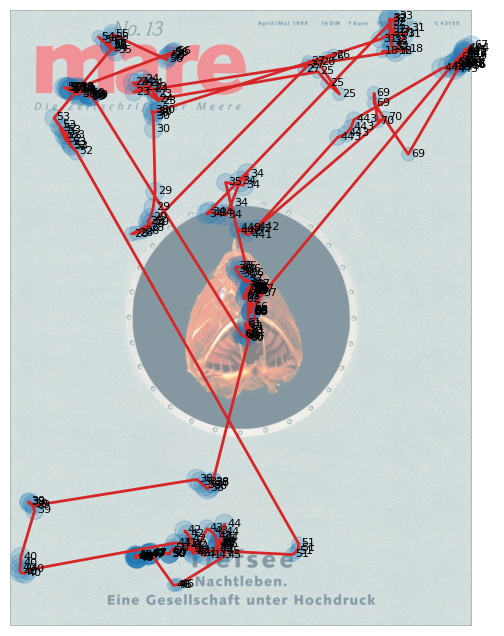

In [20]:
from scipy.ndimage.filters import gaussian_filter

grid = cover_img.shape[0:2] # height, width of the loaded image

x = fixation_on_surf["norm_pos_x"].copy()
y = fixation_on_surf["norm_pos_y"].copy()

# --- Attempt to handle unexpected large norm_pos_x values ---
# Assuming norm_pos_x was intended to be between 0 and 1.
# If values are much larger, attempt a simple re-normalization.
# This is a heuristic based on observed data and may not be universally applicable.
if (x > 100).any(): # Check if any value is significantly larger than 1
    print("Warning: norm_pos_x values are unexpectedly large. Attempting re-normalization.")
    # Assuming the largest value corresponds to the maximum extent (e.g., 1.0 if it were normalized)
    # This is a very rough estimate and might need adjustment based on actual data structure
    max_x = x.max()
    if max_x > 0:
        x = x / max_x # Simple scaling by the maximum value

# flip the fixation points
# from the original coordinate system,
# where the origin is at botton left,
# to the image coordinate system,
# where the origin is at top left
y = 1 - y

# scale up the normalized coordinates for x and y
x *= grid[1]
y *= grid[0]

point_scale = fixation_on_surf["duration"]
id_labels = list(fixation_on_surf["fixation_id"])

# display reference image
plt.figure(figsize=(8,8))
plt.imshow(cover_img, alpha=0.5)

# display the lines and points for fixation
polyline = plt.plot(x, y, "C3", lw=2)
# use the duration to determine the scatter plot circle radius
points = plt.scatter(x, y, s=point_scale, alpha=0.2)

ax = plt.gca() # get plot current axes for annotation
for i, l in enumerate(id_labels):
    ax.annotate(text=str(l), xy=(list(x)[i], list(y)[i]), xytext=(list(x)[i]+5, list(y)[i]+5), fontsize=8)


plt.axis('off');